#### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:180%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > TABLE OF CONTENTS<br><div>  
* [IMPORTS](#1)
* [INTRODUCTION](#2)
    * [CONFIGURATION](#2.1)
    * [CONFIGURATION PARAMETERS](#2.2)    
    * [DATASET COLUMNS](#2.3)
* [PREPROCESSING](#3)
* [EDA](#4)
* [DATA TRANSFORMS](#5)
* [MODEL TRAINING](#6)      
* [PLANNED WAY FORWARD](#7)     

<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > IMPORTS<br> <div> 

In [1]:
%%time 

# Installing select libraries:-
from gc import collect;
from warnings import filterwarnings;
filterwarnings('ignore');
from IPython.display import display_html, clear_output;
clear_output();

!pip install -q lightgbm==4.3.0 --force-reinstall;
!pip install --force-reinstall scikit-learn --no-index --find-links=file:///kaggle/input/scikit-learn-1-4-0/ 

clear_output();
import xgboost as xgb, lightgbm as lgb, catboost as cb, sklearn as sk, pandas as pd;
print(f"---> XGBoost = {xgb.__version__} | LightGBM = {lgb.__version__} | Catboost = {cb.__version__}");
print(f"---> Sklearn = {sk.__version__}| Pandas = {pd.__version__}\n\n");
collect();

---> XGBoost = 2.0.3 | LightGBM = 4.3.0 | Catboost = 1.2.2
---> Sklearn = 1.4.0| Pandas = 2.2.0


CPU times: user 3.82 s, sys: 826 ms, total: 4.65 s
Wall time: 1min 23s


In [2]:
%%time

# General library imports:-
from copy import deepcopy;
import pandas as pd;
import numpy as np;
import re;
from scipy.stats import mode, kstest, normaltest, shapiro, anderson, jarque_bera;
from collections import Counter;
from itertools import product;
from colorama import Fore, Style, init;
from warnings import filterwarnings;
filterwarnings('ignore');
import joblib;
import os;

from tqdm.notebook import tqdm;
import seaborn as sns;
import matplotlib.pyplot as plt;
from matplotlib.colors import ListedColormap as LCM;
%matplotlib inline

from pprint import pprint;
from functools import partial;

print();
collect();
clear_output();

CPU times: user 258 ms, sys: 33.2 ms, total: 291 ms
Wall time: 349 ms


In [3]:
%%time 

# Importing model and pipeline specifics:-
from category_encoders import OrdinalEncoder, OneHotEncoder;

# Pipeline specifics:-
from sklearn.preprocessing import (RobustScaler, 
                                   MinMaxScaler, 
                                   StandardScaler, 
                                   FunctionTransformer as FT,
                                   PowerTransformer,
                                  );
from sklearn.impute import SimpleImputer as SI;
from sklearn.model_selection import (RepeatedStratifiedKFold as RSKF, 
                                     StratifiedKFold as SKF,
                                     StratifiedGroupKFold as SGKF,
                                     KFold, 
                                     RepeatedKFold as RKF, 
                                     cross_val_score, 
                                     cross_val_predict
                                    );
from sklearn.inspection import permutation_importance;
from sklearn.feature_selection import mutual_info_classif, RFE;
from sklearn.pipeline import Pipeline, make_pipeline;
from sklearn.base import BaseEstimator, TransformerMixin;
from sklearn.compose import ColumnTransformer;

# ML Model training:-
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer;
from xgboost import DMatrix, XGBClassifier as XGBC;
from lightgbm import log_evaluation, early_stopping, LGBMClassifier as LGBMC;
from catboost import CatBoostClassifier as CBC, Pool;
from sklearn.ensemble import HistGradientBoostingClassifier as HGBC, RandomForestClassifier as RFC;

# Ensemble and tuning:-
import optuna;
from optuna import Trial, trial, create_study;
from optuna.pruners import HyperbandPruner;
from optuna.samplers import TPESampler, CmaEsSampler;
optuna.logging.set_verbosity = optuna.logging.ERROR;

clear_output();
print();
collect();


CPU times: user 1.73 s, sys: 155 ms, total: 1.89 s
Wall time: 2.21 s


In [4]:
%%time 

# Setting rc parameters in seaborn for plots and graphs- 
# Reference - https://matplotlib.org/stable/tutorials/introductory/customizing.html:-
# To alter this, refer to matplotlib.rcParams.keys()

sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.75,  
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : '#0099e6',
         'axes.titlesize'       : 8.5,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,        
        });

# Color printing    
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    "Prints color outputs using colorama using a text F-string";
    print(style + color + text + Style.RESET_ALL); 

# Making sklearn pipeline outputs as dataframe:-
from sklearn import set_config; 
set_config(transform_output = "pandas");
pd.set_option('display.max_columns', 50);
pd.set_option('display.max_rows', 50);

print();
collect();



CPU times: user 134 ms, sys: 0 ns, total: 134 ms
Wall time: 135 ms


<a id="2"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > INTRODUCTION<br><div> 

| Version<br>Number | Version Details | CV score| Single/ Ensemble|Public LB Score|
| :-: | --- | :-: | :-: |:-:|
| **V1** |* Excluded original data <br> * Independent binary classification <br> * 10x1 SKF ML models and Optuna ensemble|0.89274|Ensemble <br> Optuna|0.89355|
| **V2** |* Excluded original data <br> * Independent binary classification <br> * 10x1 SKF ML models and Optuna ensemble <br> * Added public work and blended results|0.89265|Ensemble <br> Optuna|0.89476|
| **V3** |* Included original data <br> * Independent binary classification <br> * 10x1 SKF ML models and Optuna ensemble <br> * Added public work and blended results|0.90088|Ensemble <br> Optuna|0.89397|
| **V4** |* Same as V3 <br> * Blended with good public work|0.90088|Ensemble <br> Optuna|0.89613|
| **V5** |* Added extra features <br> * ML Models and Optuna ensemble <br> * Blended with good public work|0.90090|Ensemble <br> Optuna|0.89615|
| **V6** |* Added more extra features <br> * ML Models and Optuna ensemble <br> * Blended with good public work|0.90090|Ensemble <br> Optuna|0.89645|
| **V7** |* Added more extra features and dropped worst features <br> * ML Models and Optuna ensemble <br> * Blended with good public work||Ensemble <br> Optuna||

<a id="2.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: black; font-size:120%; text-align:left;padding:3.0px; background: #c2d6d6; border-bottom: 8px solid black" > CONFIGURATION<br><div> 

In [5]:
%%time

# Configuration class:-
class CFG:
    """
    Configuration class for parameters and CV strategy for tuning and training
    Some parameters may be unused here as this is a general configuration class
    """;
    
    # Data preparation:-   
    version_nb         = 7;
    test_req           = "Y";
    test_sample_frac   = 0.025;
    gpu_switch         = "OFF"; 
    state              = 42;
    targets            = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'];
    episode            = 3;
    season             = 4;
    path               = f"/kaggle/input/playground-series-s{season}e{episode}";
    orig_path          = f"/kaggle/input/playgrounds4e03ancillary/PlaygroundS4E3Original.csv";
    
    dtl_preproc_req    = "Y";
    ftre_plots_req     = 'Y';
    ftre_imp_req       = "Y";
    
    # Data transforms and scaling:-    
    conjoin_orig_data  = "Y";
    drop_nulls         = "N";
    sec_ftre_req       = "Y";
    scale_req          = "N";
    
    # Model Training:- 
    pstprcs_oof        = "N";
    pstprcs_train      = "N";
    pstprcs_test       = "N";
    ML                 = "Y";
    
    pseudo_lbl_req     = "N";
    pseudolbl_up       = 0.975;
    pseudolbl_low      = 0.00;
    
    n_splits           = 3 if test_req == "Y" else 10;
    n_repeats          = 1 ;
    nbrnd_erly_stp     = 75;
    mdlcv_mthd         = 'RSKF';
    
    # Ensemble:-    
    ensemble_req       = "Y";
    hill_climb_req     = "N";
    optuna_req         = "Y";
    LAD_req            = "N";
    enscv_mthd         = "RSKF";
    metric_obj         = 'maximize';
    ntrials            = 10 if test_req == "Y" else 100;
    
    # Global variables for plotting:-
    grid_specs = {'visible': True, 'which': 'both', 'linestyle': '--', 
                           'color': 'lightgrey', 'linewidth': 0.75};
    title_specs = {'fontsize': 9, 'fontweight': 'bold', 'color': '#992600'};

print();
PrintColor(f"--> Configuration done!\n");
collect();


--> Configuration done!

CPU times: user 135 ms, sys: 793 µs, total: 136 ms
Wall time: 135 ms


<a id="2.2"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: black; font-size:120%; text-align:left;padding:3.0px; background: #e5e5cc; border-bottom: 8px solid black" > CONFIGURATION PARAMETERS<br><div> 


| Parameter         | Description                                             | Possible value choices|
| ---               | ---                                                     | :-:                   |
|  version_nb       | Version Number                                          | integer               |
|  test_req         | Are we testing syntax here?                             | Y/N                   |  
|  test_sample_frac | Sample size for syntax test                             | float(0-1)/ int       |     
|  gpu_switch       | GPU switch                                              | ON/OFF                |
|  state            | Random state for most purposes                          | integer               |
|  targets          | Target column names                                     | list                  |
|  episode          | Episode Number                                          | integer               |
|  season           | Season Number                                           | integer               |    
|  path             | Path for input data files                               |                       |
|  orig_path        | Path for input original data files                      |                       |
|  dtl_preproc_req  | Proprocessing required                                  | Y/N                   |    
|  ftre_plots_req   | Feature plots required                                  | Y/N                   |
|  ftre_imp_req     | Feature importance required                             | Y/N                   |
|  conjoin_orig_data| Conjoin original data                                   | Y/N                   |
|  drop_nulls       | Drop original data nulls                                | Y/N                   |    
|  sec_ftre_req     | Secondary features required                             | Y/N                   |  
|  pstprcs_oof      | Post-process OOF after model training                   | Y/N                   |
|  pstprcs_train    | Post-process OOF during model training for dev-set      | Y/N                   |
|  pstprcs_test     | Post-process test after training                        | Y/N                   |
|  ML               | Machine Learning Models                                 | Y/N                   |
|  use_orig_all_folds| Use original data in all folds                         | Y/N                   |
|  n_splits         | Number of CV splits                                     | integer               |
|  n_repeats        | Number of CV repeats                                    | integer               |
|  nbrnd_erly_stp   | Number of early stopping rounds                         | integer               |
|  mdl_cv_mthd      | Model CV method name                                    | RKF/ RSKF/ SKF/ KFold |

<a id="2.3"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: black; font-size:120%; text-align:left;padding:3.0px; background: #e5e5cc; border-bottom: 8px solid black" > APPROACH DETAILS<br><div> 
    
**Data columns**<br>
This is available in the original data description as below<br>
 <br>
<br>**Competition details and notebook objectives**<br>
1. This is a binary classification challenge with multiple targets to predict steel manufacturing component fault details. **GINI average score** is the metric for the challenge<br>
2. In this starter notebook, we start the assignment with a detailed EDA, feature plots, interaction effects, adversarial CV analysis and develop starter models to initiate the challenge. We will also incorporate other opinions and approaches as we move along the challenge.<br>
<br>
**Model strategy** <br>
We start off with simple tree based ML models (binary classifiers across individual targets) and an Optuna ensemble to create sample inputs for the submission. <br>

<a id="3"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > PREPROCESSING<br><div> 

In [6]:
%time 

class Preprocessor():
    """
    This class aims to do the below-
    1. Read the datasets
    2. In this case, process the original data
    3. Check information and description
    4. Check unique values and nulls
    5. Collate starting features 
    6. Conjoin train-original data if requested based on Adversarial CV results
    """;
    
    def __init__(self):
        self.train             = pd.read_csv(os.path.join(CFG.path,"train.csv"), index_col = 'id');
        self.test              = pd.read_csv(os.path.join(CFG.path ,"test.csv"), index_col = 'id');
        self.targets           = CFG.targets ;
        self.original          = pd.read_csv(CFG.orig_path, index_col = "id");
        self.conjoin_orig_data = CFG.conjoin_orig_data;
        self.dtl_preproc_req   = CFG.dtl_preproc_req;
        self.test_req          = CFG.test_req;
        
        self.sub_fl   = pd.read_csv(os.path.join(CFG.path, "sample_submission.csv"));
        PrintColor(f"Data shapes - train-test-original | {self.train.shape} {self.test.shape} {self.original.shape}");
        
        for tbl in [self.train, self.original, self.test]:
            tbl.columns = tbl.columns.str.replace(r"\(|\)|\s+","", regex = True);
            
        PrintColor(f"\nTrain set head", color = Fore.CYAN);
        display(self.train.head(5).style.format(precision = 3));
        PrintColor(f"\nTest set head", color = Fore.CYAN);
        display(self.test.head(5).style.format(precision = 3));
        PrintColor(f"\nOriginal set head", color = Fore.CYAN);
        display(self.original.head(5).style.format(precision = 3));
                 
        # Resetting original data index:-
        self.original.index = range(len(self.original));
        self.original.index+= max(self.test.index) + 1;
        self.original.index.name = 'id';
        
        #  Changing original data column order to match the competition column structure:-
        self.original = self.original.reindex(self.train.columns, axis=1);
              
    def _AddSourceCol(self):
        self.train['Source']    = "Competition";
        self.test['Source']     = "Competition";
        self.original['Source'] = 'Original';
        
        self.strt_ftre = self.test.columns;
        return self;
          
    def _CollateInfoDesc(self):
        if self.dtl_preproc_req == "Y":
            PrintColor(f"\n{'-'*20} Information and description {'-'*20}\n", color = Fore.MAGENTA);

            # Creating dataset information and description:
            for lbl, df in {'Train': self.train, 'Test': self.test, 'Original': self.original}.items():
                PrintColor(f"\n{lbl} description\n");
                display(df.describe(percentiles= [0.05, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]).\
                        transpose().\
                        drop(columns = ['count'], errors = 'ignore').\
                        drop([self.targets], axis=0, errors = 'ignore').\
                        style.format(formatter = '{:,.2f}').\
                        background_gradient(cmap = 'Blues')
                       );

                PrintColor(f"\n{lbl} information\n");
                display(df.info());
                collect();
        return self;
    
    def _CollateUnqNull(self):
        
        if self.dtl_preproc_req == "Y":
            # Dislaying the unique values across train-test-original:-
            PrintColor(f"\nUnique and null values\n");
            _ = pd.concat([self.train[self.strt_ftre].nunique(), 
                           self.test[self.strt_ftre].nunique(), 
                           self.original[self.strt_ftre].nunique(),
                           self.train[self.strt_ftre].isna().sum(axis=0),
                           self.test[self.strt_ftre].isna().sum(axis=0),
                           self.original[self.strt_ftre].isna().sum(axis=0)
                          ], 
                          axis=1);
            _.columns = ['Train_Nunq', 'Test_Nunq', 'Original_Nunq', 
                         'Train_Nulls', 'Test_Nulls', 'Original_Nulls'
                        ];

            display(_.T.style.background_gradient(cmap = 'Blues', axis=1).\
                    format(formatter = '{:,.0f}')
                   );
            
        return self;
    
    def _ConjoinTrainOrig(self):
        if self.conjoin_orig_data == "Y":
            PrintColor(f"\n\nTrain shape before conjoining with original = {self.train.shape}");
            train = pd.concat([self.train, self.original], axis=0, ignore_index = True);
            PrintColor(f"Train shape after conjoining with original= {train.shape}");

            train = train.drop_duplicates();
            PrintColor(f"Train shape after de-duping = {train.shape}");

            train.index = range(len(train));
            train.index.name = 'id';

        else:
            PrintColor(f"\nWe are using the competition training data only");
            train = self.train;
        return train;
       
    def DoPreprocessing(self):
        self._AddSourceCol();
        self._CollateInfoDesc();
        self._CollateUnqNull();
        self.train = self._ConjoinTrainOrig();
        self.train.index = range(len(self.train));
        
        _ = pp.train.drop(columns = CFG.targets + ['Source']).nunique();
        self.cat_cols  = _.loc[_ <=10].index.to_list();
        self.cont_cols = [c for c in _.index if c not in self.cat_cols + ['Source']];
        return self; 
            
collect();
print();

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.78 µs



In [7]:
%%time 

pp = Preprocessor();
pp.DoPreprocessing();

print();
collect();

Data shapes - train-test-original | (19219, 34) (12814, 27) (1941, 34)

Train set head


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.739,0.400,0.500,0.006,1.000,1.000,0.000,1.204,0.903,0.699,-0.500,-0.010,0.142,0,0,0,1,0,0,0
1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.777,0.288,0.258,0.004,0.250,1.000,1.000,2.636,0.778,1.732,0.742,-0.300,0.949,0,0,0,0,0,0,1
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.056,0.528,0.990,0.108,0.236,0.386,0.000,4.056,2.179,2.209,-0.011,-0.094,1.000,0,0,1,0,0,0,0
3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.720,0.333,0.333,0.004,0.375,0.931,1.000,2.322,0.778,1.431,0.667,-0.040,0.403,0,0,1,0,0,0,0
4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.121,0.535,0.084,0.019,0.210,0.986,1.000,2.769,1.415,1.881,0.916,-0.245,1.000,0,0,0,0,0,0,1



Test set head


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
19219,1015,1033,3826564,3826588,659,23,46,62357,67,127,1656,0,1,150,0.388,0.490,0.327,0.009,0.565,1.000,1.000,2.841,1.114,1.663,0.673,-0.226,0.917
19220,1257,1271,419960,419973,370,26,28,39293,92,132,1354,0,1,40,0.163,0.414,0.094,0.005,0.241,1.000,1.000,2.568,0.903,1.447,0.906,-0.145,0.910
19221,1358,1372,117715,117724,289,36,32,29386,101,134,1360,0,1,40,0.061,0.623,0.476,0.015,0.600,0.750,0.000,2.461,1.322,1.322,-0.524,-0.043,0.651
19222,158,168,232415,232440,80,10,11,8586,107,140,1690,1,0,100,0.444,0.333,0.818,0.004,0.800,1.000,1.000,1.903,0.699,1.041,0.182,-0.074,0.205
19223,559,592,544375,544389,140,19,15,15524,103,134,1688,1,0,60,0.819,0.262,0.429,0.016,0.842,0.533,0.000,2.146,1.322,1.146,-0.571,-0.089,0.417



Original set head


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.050,0.241,0.182,0.005,0.471,1.000,1.000,2.426,0.903,1.643,0.818,-0.291,0.582,1,0,0,0,0,0,0
2,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.765,0.379,0.207,0.004,0.600,0.967,1.000,2.033,0.778,1.462,0.793,-0.176,0.298,1,0,0,0,0,0,0
3,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.971,0.343,0.333,0.004,0.750,0.947,1.000,1.851,0.778,1.255,0.667,-0.123,0.215,1,0,0,0,0,0,0
4,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.729,0.441,0.156,0.005,0.538,1.000,1.000,2.245,0.845,1.653,0.844,-0.157,0.521,1,0,0,0,0,0,0
5,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.070,0.449,0.066,0.013,0.283,0.989,1.000,3.382,1.230,2.410,0.934,-0.199,1.000,1,0,0,0,0,0,0



-------------------- Information and description --------------------


Train description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
X_Minimum,709.85,531.54,0.00,14.00,49.00,777.00,"1,152.00","1,358.00","1,579.00","1,673.00","1,705.00"
X_Maximum,753.86,499.84,4.00,27.00,214.00,796.00,"1,165.00","1,372.00","1,592.00","1,684.00","1,713.00"
Y_Minimum,"1,849,756.04","1,903,553.85","6,712.00","96,812.00","657,468.00","1,398,169.00","2,368,032.00","3,986,260.00","5,367,324.00","10,391,495.00","12,987,661.00"
Y_Maximum,"1,846,605.35","1,896,295.14","6,724.00","97,109.80","657,502.00","1,398,179.00","2,362,511.00","3,981,797.20","5,367,377.00","10,391,507.00","12,987,692.00"
Pixels_Areas,"1,683.99","3,730.32",6.00,51.00,89.00,168.00,653.00,"6,432.00","9,596.10","16,052.00","152,655.00"
X_Perimeter,95.65,177.82,2.00,9.00,15.00,25.00,64.00,275.00,578.00,795.00,"7,553.00"
Y_Perimeter,64.12,101.05,1.00,7.00,14.00,23.00,61.00,143.00,357.00,482.00,903.00
Sum_of_Luminosity,"191,846.68","442,024.69",250.00,"4,674.00","9,848.00","18,238.00","67,978.00","674,326.00","1,238,454.00","1,877,827.00","11,591,414.00"
Minimum_of_Luminosity,84.81,28.80,0.00,35.00,70.00,90.00,105.00,115.00,120.00,151.00,196.00
Maximum_of_Luminosity,128.65,14.20,39.00,108.00,124.00,127.00,135.00,141.00,143.00,182.00,253.00



Train information

<class 'pandas.core.frame.DataFrame'>
Index: 19219 entries, 0 to 19218
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              19219 non-null  int64  
 1   X_Maximum              19219 non-null  int64  
 2   Y_Minimum              19219 non-null  int64  
 3   Y_Maximum              19219 non-null  int64  
 4   Pixels_Areas           19219 non-null  int64  
 5   X_Perimeter            19219 non-null  int64  
 6   Y_Perimeter            19219 non-null  int64  
 7   Sum_of_Luminosity      19219 non-null  int64  
 8   Minimum_of_Luminosity  19219 non-null  int64  
 9   Maximum_of_Luminosity  19219 non-null  int64  
 10  Length_of_Conveyer     19219 non-null  int64  
 11  TypeOfSteel_A300       19219 non-null  int64  
 12  TypeOfSteel_A400       19219 non-null  int64  
 13  Steel_Plate_Thickness  19219 non-null  int64  
 14  Edges_Index            19219 non-null  

None


Test description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
X_Minimum,709.33,531.88,0.00,13.00,46.00,776.00,"1,152.00","1,357.00","1,575.00","1,673.00","1,688.00"
X_Maximum,753.27,500.74,4.00,24.00,214.00,796.00,"1,167.00","1,372.00","1,590.00","1,684.00","1,712.00"
Y_Minimum,"1,846,533.46","1,916,427.39","6,712.00","96,205.00","640,173.75","1,378,890.50","2,368,032.00","3,996,148.00","5,437,033.00","10,391,495.00","12,987,661.00"
Y_Maximum,"1,842,029.49","1,911,425.61","6,724.00","96,225.00","639,857.00","1,378,588.00","2,356,237.50","3,996,170.00","5,437,060.00","10,391,507.00","12,987,692.00"
Pixels_Areas,"1,672.91","3,725.52",4.00,51.00,91.00,169.00,649.00,"6,430.00","8,709.00","15,896.00","152,655.00"
X_Perimeter,96.46,219.93,2.00,9.00,15.00,24.00,64.00,274.00,577.35,796.00,"10,449.00"
Y_Perimeter,64.73,188.51,2.00,7.00,14.00,24.00,60.00,142.00,355.00,480.00,"18,152.00"
Sum_of_Luminosity,"192,689.30","481,287.15",535.00,"4,712.00","9,968.00","18,402.00","66,960.25","673,434.00","1,095,823.75","1,877,827.00","11,591,414.00"
Minimum_of_Luminosity,84.55,28.71,0.00,36.00,68.00,90.00,105.00,115.00,120.00,150.00,203.00
Maximum_of_Luminosity,128.69,14.28,37.00,108.00,124.00,127.00,135.00,141.00,143.00,182.00,253.00



Test information

<class 'pandas.core.frame.DataFrame'>
Index: 12814 entries, 19219 to 32032
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              12814 non-null  int64  
 1   X_Maximum              12814 non-null  int64  
 2   Y_Minimum              12814 non-null  int64  
 3   Y_Maximum              12814 non-null  int64  
 4   Pixels_Areas           12814 non-null  int64  
 5   X_Perimeter            12814 non-null  int64  
 6   Y_Perimeter            12814 non-null  int64  
 7   Sum_of_Luminosity      12814 non-null  int64  
 8   Minimum_of_Luminosity  12814 non-null  int64  
 9   Maximum_of_Luminosity  12814 non-null  int64  
 10  Length_of_Conveyer     12814 non-null  int64  
 11  TypeOfSteel_A300       12814 non-null  int64  
 12  TypeOfSteel_A400       12814 non-null  int64  
 13  Steel_Plate_Thickness  12814 non-null  int64  
 14  Edges_Index            12814 non-nul

None


Original description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
X_Minimum,571.14,520.69,0.00,14.00,51.00,435.00,"1,053.00","1,324.00","1,538.00","1,654.80","1,705.00"
X_Maximum,617.96,497.63,4.00,29.00,192.00,467.00,"1,072.00","1,332.00","1,561.00","1,675.40","1,713.00"
Y_Minimum,"1,650,684.87","1,774,578.41","6,712.00","86,773.00","471,253.00","1,204,128.00","2,183,073.00","3,597,508.00","4,532,922.00","10,359,325.20","12,987,661.00"
Y_Maximum,"1,650,738.71","1,774,590.09","6,724.00","86,815.00","471,281.00","1,204,136.00","2,183,084.00","3,597,517.00","4,532,948.00","10,359,343.20","12,987,692.00"
Pixels_Areas,"1,893.88","5,168.46",2.00,39.00,84.00,174.00,822.00,"6,381.00","11,211.00","18,033.40","152,655.00"
X_Perimeter,111.86,301.21,2.00,9.00,15.00,26.00,84.00,285.00,616.00,863.40,"10,449.00"
Y_Perimeter,82.97,426.48,1.00,7.00,13.00,25.00,83.00,172.00,381.00,539.00,"18,152.00"
Sum_of_Luminosity,"206,312.15","512,293.59",250.00,"4,347.00","9,522.00","19,202.00","83,011.00","660,910.00","1,293,558.00","2,155,800.80","11,591,414.00"
Minimum_of_Luminosity,84.55,32.13,0.00,29.00,63.00,90.00,106.00,118.00,124.00,170.80,203.00
Maximum_of_Luminosity,130.19,18.69,37.00,102.00,124.00,127.00,140.00,143.00,156.00,199.00,253.00



Original information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 32033 to 33973
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1941 non-null   int64  
 1   X_Maximum              1941 non-null   int64  
 2   Y_Minimum              1941 non-null   int64  
 3   Y_Maximum              1941 non-null   int64  
 4   Pixels_Areas           1941 non-null   int64  
 5   X_Perimeter            1941 non-null   int64  
 6   Y_Perimeter            1941 non-null   int64  
 7   Sum_of_Luminosity      1941 non-null   int64  
 8   Minimum_of_Luminosity  1941 non-null   int64  
 9   Maximum_of_Luminosity  1941 non-null   int64  
 10  Length_of_Conveyer     1941 non-null   int64  
 11  TypeOfSteel_A300       1941 non-null   int64  
 12  TypeOfSteel_A400       1941 non-null   int64  
 13  Steel_Plate_Thickness  1941 non-null   int64  
 14  Edges_Index            1941 

None


Unique and null values



,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Source
Train_Nunq,"1,191","1,259","3,345","3,341","1,154",460,331,"2,595",162,98,99,2,2,27,"1,849","1,748","1,118",525,"1,102",900,4,"1,072",206,241,"1,598","2,046",467,1
Test_Nunq,"1,131","1,188","2,781","2,827","1,070",435,316,"2,300",161,99,92,2,2,24,"1,697","1,606",987,480,998,788,3,994,189,218,"1,382","1,887",427,1
Original_Nunq,962,994,"1,939","1,940",920,399,317,"1,909",161,100,84,2,2,24,"1,387","1,338",770,454,818,648,3,914,183,217,918,"1,522",388,1
Train_Nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Test_Nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Original_Nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0




Train shape before conjoining with original = (19219, 35)
Train shape after conjoining with original= (21160, 35)
Train shape after de-duping = (21160, 35)

CPU times: user 1.45 s, sys: 75.3 ms, total: 1.53 s
Wall time: 1.64 s


<a id="3.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: black; font-size:120%; text-align:left;padding:3.0px; background: #e5e5cc; border-bottom: 8px solid black" > INFERENCES<br><div> 

<div style= "font-family: Cambria; letter-spacing: 0px; color:#000000; font-size:110%; text-align:left;padding:3.0px; background: #f2f2f2" >
1. We have numerical columns with no nulls<br>
2. The dataset is quite small, so building a CV is difficult- luck will play a huge part in this challenge<br>
</div>

<a id="4"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > EDA<br><div> 

In [8]:
%%time 

class FeaturePlotter(CFG, Preprocessor):
    """
    This class develops plots for the targets, continuous and category features
    """;
    
    def __init__(self):
        super().__init__();
        clear_output();
        
    def MakeTgtPlot(self):
        "This method returns the target plots";
        
        if self.ftre_plots_req == "Y":
            for target in self.targets:
                fig, axes = plt.subplots(1,2, figsize = (10, 3), sharey = True, gridspec_kw = {'wspace': 0.35});
                for i, df in tqdm(enumerate([self.train, self.original]), f"Target plot- {target} ---> "):
                    ax= axes[i];
                    a = df[target].value_counts(normalize = True);
                    a.sort_index().plot.bar(color = 'tab:blue', ax = ax);
                    df_name = 'Train' if i == 0 else "Original";
                    _ = ax.set_title(f"\n{df_name} data- {target}\n", **CFG.title_specs);
                    ax.set_yticks(np.arange(0,1.01, 0.08), labels = np.around(np.arange(0,1.01, 0.08), 2), fontsize = 7.0)

                plt.tight_layout();
                plt.show();
                
    def MakeCatFtrePlots(self, cat_cols):
        "This method returns the category feature plots";
        
        if cat_cols != [] and self.ftre_plots_req == "Y":
            fig, axes = plt.subplots(len(cat_cols), 3, figsize = (20, len(cat_cols)* 4.5), 
                                     gridspec_kw = {'wspace': 0.25, 'hspace': 0.3});

            for i, col in enumerate(cat_cols):
                ax = axes[i, 0];
                a = self.train[col].value_counts(normalize = True);
                a.sort_index().plot.barh(ax = ax, color = '#007399');
                ax.set_title(f"{col}_Train", **self.title_specs);
                ax.set_xticks(np.arange(0.0, 0.9, 0.05), 
                              labels = np.round(np.arange(0.0, 0.9, 0.05),2), 
                              rotation = 90
                             );
                ax.set(xlabel = '', ylabel = '');
                del a;

                ax = axes[i, 1];
                a = self.test[col].value_counts(normalize = True);
                a.sort_index().plot.barh(ax = ax, color = '#0088cc');
                ax.set_title(f"{col}_Test", **self.title_specs);
                ax.set_xticks(np.arange(0.0, 0.9, 0.05), 
                              labels = np.round(np.arange(0.0, 0.9, 0.05),2), 
                              rotation = 90
                             );
                ax.set(xlabel = '', ylabel = '');
                del a;

                ax = axes[i, 2];
                a = self.original[col].value_counts(normalize = True);
                a.sort_index().plot.barh(ax = ax, color = '#0047b3');
                ax.set_title(f"{col}_Original", **self.title_specs);
                ax.set_xticks(np.arange(0.0, 0.9, 0.05), 
                              labels = np.round(np.arange(0.0, 0.9, 0.05),2), 
                              rotation = 90
                             );
                ax.set(xlabel = '', ylabel = '');
                del a;       

            plt.suptitle(f"Category column plots", **self.title_specs, y= 0.94);
            plt.tight_layout();
            plt.show();
            
    def MakeContColPlots(self, cont_cols):
        "This method returns the continuous feature plots";
        
        if self.ftre_plots_req == "Y":
            df = pd.concat([self.train[cont_cols].assign(Source = 'Train'), 
                            self.test[cont_cols].assign(Source = 'Test'),
                            self.original[cont_cols].assign(Source = "Original")
                           ], 
                           axis=0, ignore_index = True
                          );

            fig, axes = plt.subplots(len(cont_cols), 4 ,figsize = (16, len(cont_cols) * 4.2), 
                                     gridspec_kw = {'hspace': 0.35, 
                                                    'wspace': 0.3, 
                                                    'width_ratios': [0.80, 0.20, 0.20, 0.20]
                                                   }
                                    );

            for i,col in enumerate(cont_cols):
                ax = axes[i,0];
                sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', 
                            palette = ['#0039e6', '#ff5500', '#00b300'], 
                            ax = ax, linewidth = 2.1
                           );
                ax.set_title(f"\n{col}", **self.title_specs);
                ax.grid(**CFG.grid_specs);
                ax.set(xlabel = '', ylabel = '');

                ax = axes[i,1];
                sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25,
                            color = '#33ccff', saturation = 0.90, linewidth = 0.90, 
                            fliersize= 2.25,
                            ax = ax);
                ax.set(xlabel = '', ylabel = '');
                ax.set_title(f"Train", **self.title_specs);

                ax = axes[i,2];
                sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, fliersize= 2.25,
                            color = '#80ffff', saturation = 0.6, linewidth = 0.90, 
                            ax = ax); 
                ax.set(xlabel = '', ylabel = '');
                ax.set_title(f"Test", **self.title_specs);

                ax = axes[i,3];
                sns.boxplot(data = df.loc[df.Source == 'Original', [col]], y = col, width = 0.25, fliersize= 2.25,
                            color = '#99ddff', saturation = 0.6, linewidth = 0.90, 
                            ax = ax); 
                ax.set(xlabel = '', ylabel = '');
                ax.set_title(f"Original", **self.title_specs);

            plt.suptitle(f"\nDistribution analysis- continuous columns\n", **CFG.title_specs, 
                         y = 0.89, x = 0.50
                        );
            plt.tight_layout();
            plt.show();
     
    def CalcSkew(self, cont_cols):
        "This method calculates the skewness across columns";
        
        if self.ftre_plots_req == "Y": 
            skew_df = pd.DataFrame(index = cont_cols);
            for col, df in {"Train"   : self.train[cont_cols], 
                            "Test"    : self.test[cont_cols], 
                            "Original": self.original[cont_cols]
                           }.items():   
                skew_df = \
                pd.concat([skew_df, 
                           df.drop(columns = self.targets + ["Source", "id"], errors = "ignore").skew()],
                           axis=1).rename({0: col}, axis=1);

            PrintColor(f"\nSkewness across independent features\n");
            display(skew_df.transpose().style.format(precision = 2).background_gradient("PuBuGn"));

print();
collect();
  


CPU times: user 135 ms, sys: 0 ns, total: 135 ms
Wall time: 135 ms


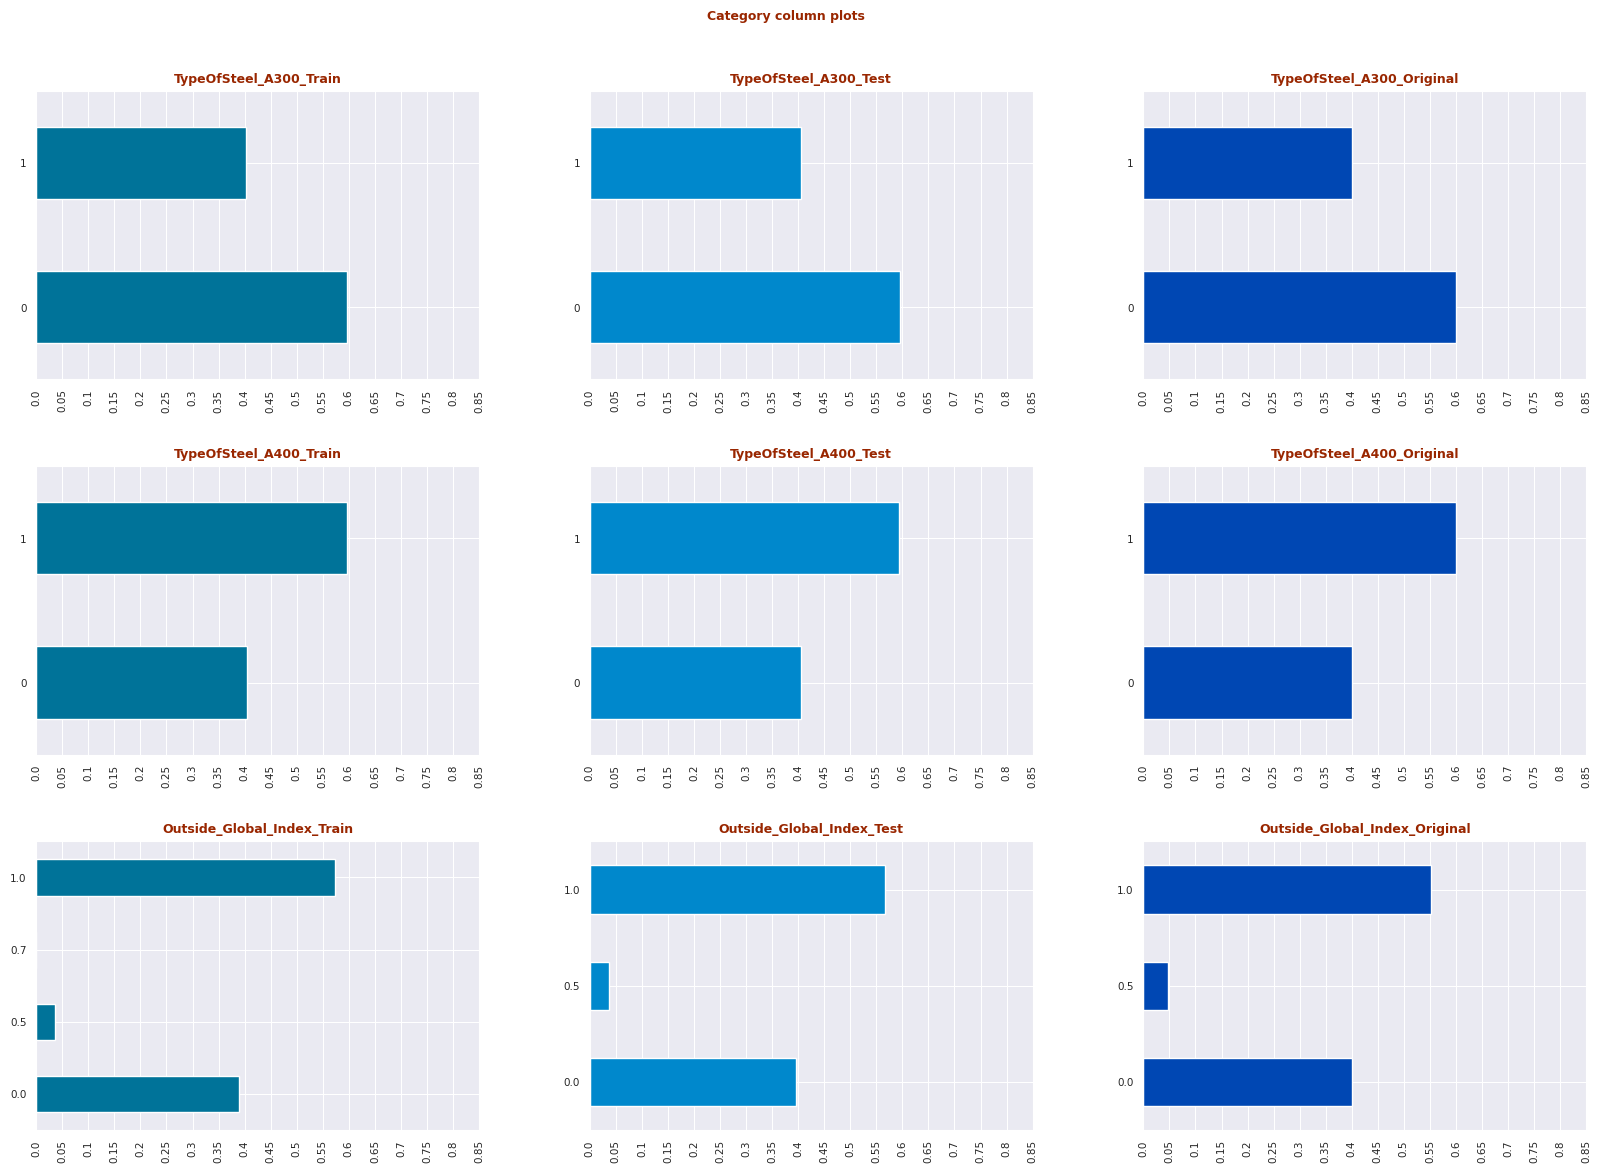

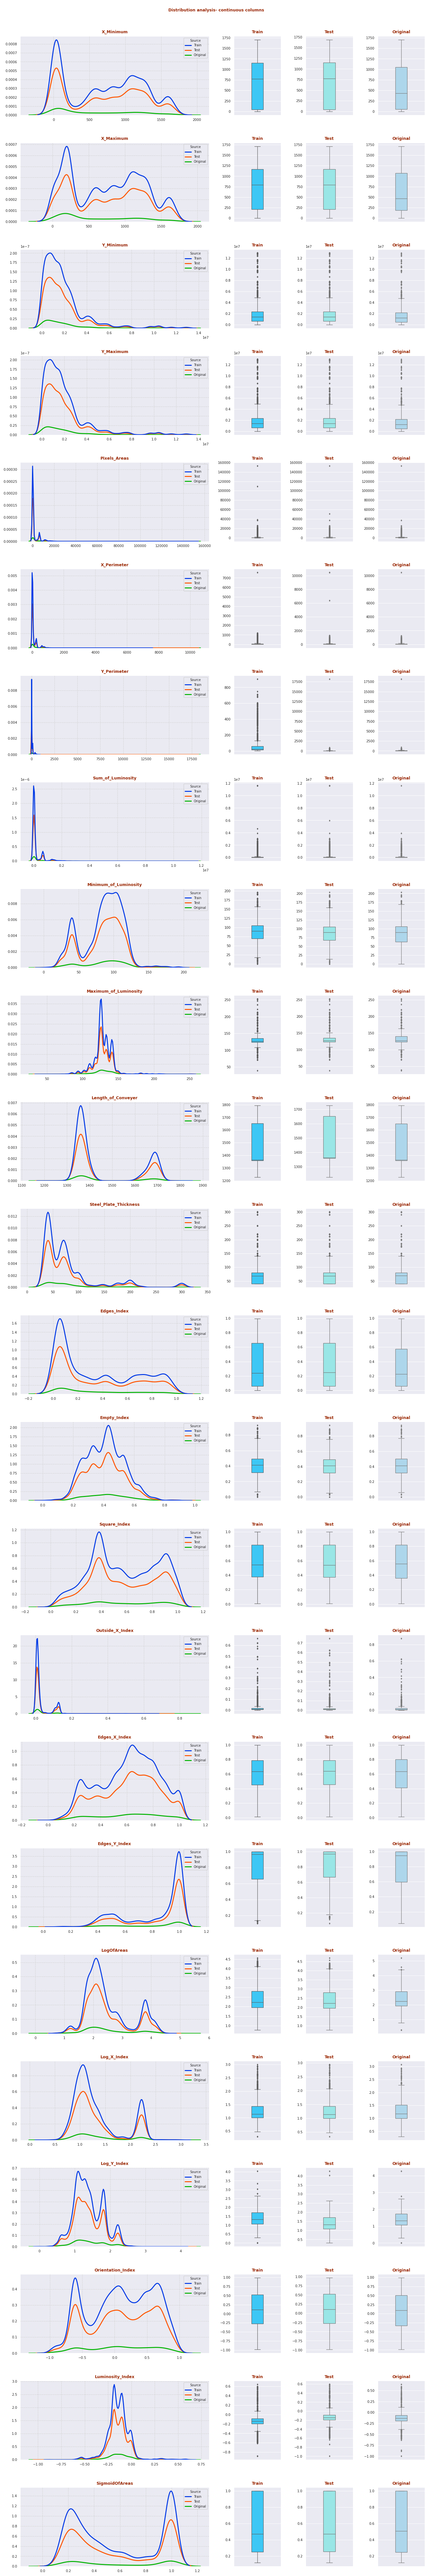

Target plot- Pastry ---> : 0it [00:00, ?it/s]

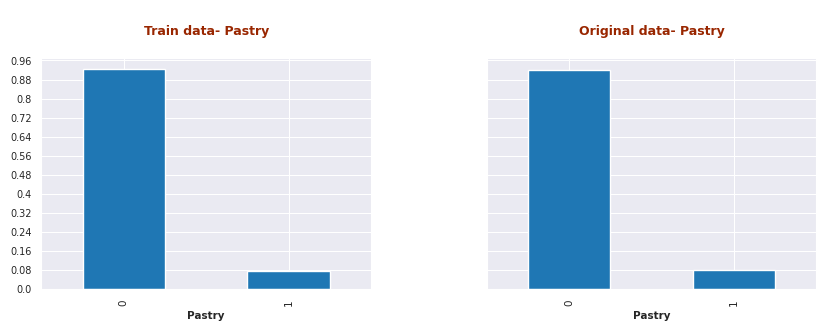

Target plot- Z_Scratch ---> : 0it [00:00, ?it/s]

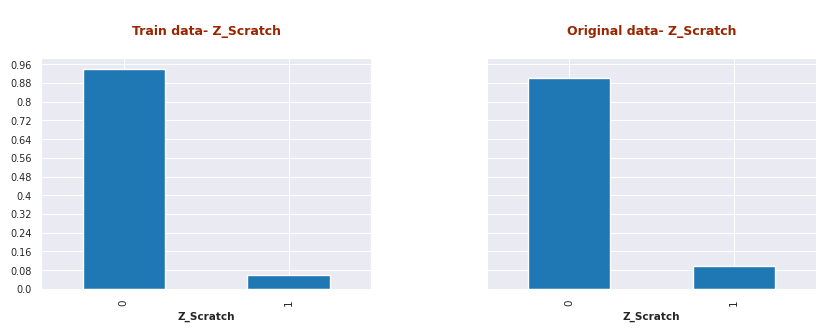

Target plot- K_Scatch ---> : 0it [00:00, ?it/s]

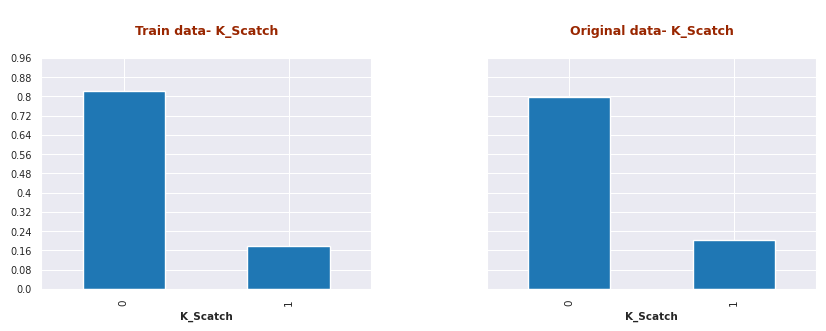

Target plot- Stains ---> : 0it [00:00, ?it/s]

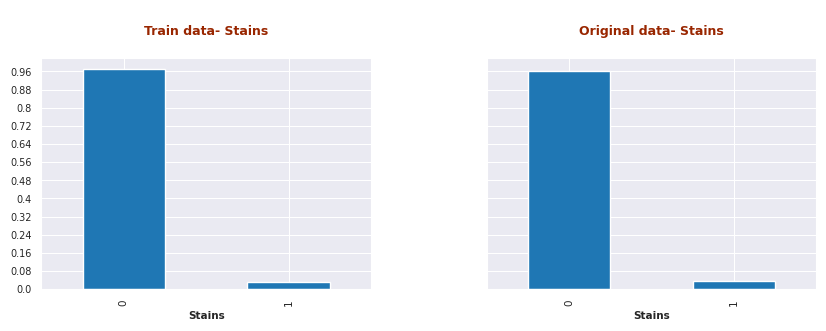

Target plot- Dirtiness ---> : 0it [00:00, ?it/s]

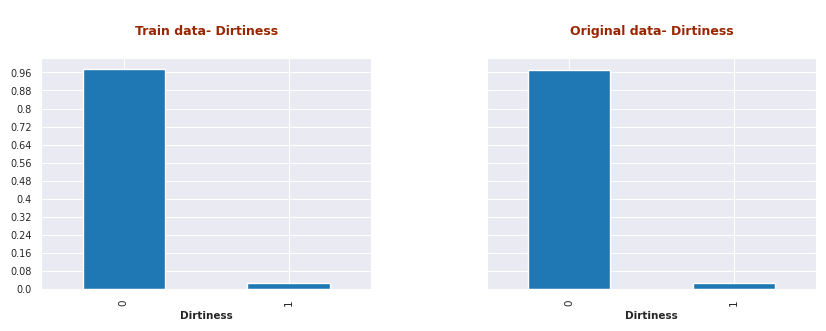

Target plot- Bumps ---> : 0it [00:00, ?it/s]

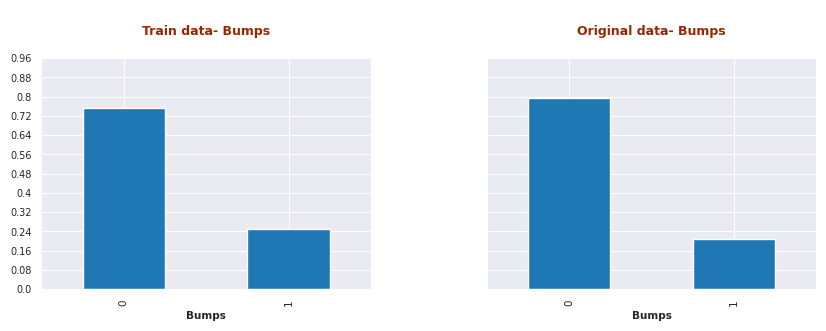

Target plot- Other_Faults ---> : 0it [00:00, ?it/s]

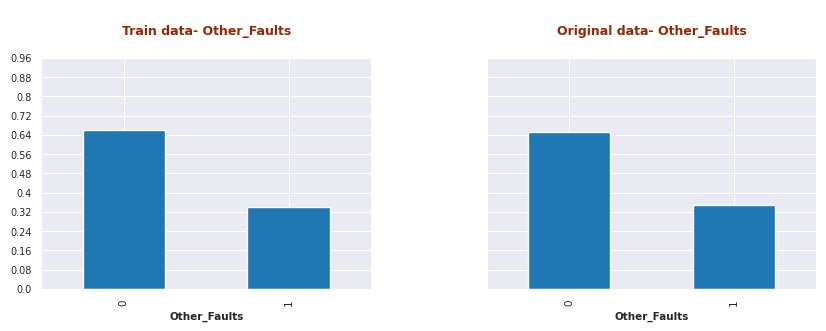






Skewness across independent features



,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
Train,0.02,0.07,2.58,2.57,6.98,6.32,2.98,6.69,-0.33,1.17,0.86,2.36,0.54,0.20,0.01,3.12,-0.25,-0.98,0.86,1.10,0.39,-0.19,0.78,0.22
Test,0.01,0.06,2.56,2.56,7.60,19.42,69.40,9.06,-0.33,1.36,0.85,2.40,0.53,0.23,0.03,3.63,-0.26,-1.00,0.85,1.11,0.42,-0.18,0.63,0.22
Original,0.50,0.52,2.81,2.81,14.08,21.54,39.29,7.73,-0.11,1.29,0.85,2.21,0.69,0.29,-0.06,5.18,-0.24,-0.93,0.75,1.00,0.45,-0.15,0.68,0.13



CPU times: user 50.3 s, sys: 18.4 s, total: 1min 8s
Wall time: 40.8 s


In [9]:
%%time 

plotter = FeaturePlotter();
plotter.MakeCatFtrePlots(cat_cols = pp.cat_cols)

print(f"\n\n\n");
plotter.MakeContColPlots(cont_cols = pp.cont_cols);

print(f"\n\n\n");
plotter.MakeTgtPlot();

print(f"\n\n\n");
plotter.CalcSkew(cont_cols = pp.cont_cols);

print();
collect();    

<a id="5"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > DATA TRANSFORMS<br><div> 

In [10]:
%%time 

# Data transforms:-
class Xformer(TransformerMixin, BaseEstimator):
    """
    This class adds secondary features to the existing data using simple interactions
    """;
    
    def __init__(self): 
        self.sec_ftre_req = CFG.sec_ftre_req;
    
    def fit(self, X, y= None, **params):
        return self;
    
    @staticmethod
    def _reduce_mem(df: pd.DataFrame):
        "This method reduces memory for numeric columns in the dataframe";
        
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', "uint16", "uint32", "uint64"];
        start_mem = df.memory_usage().sum() / 1024**2;
        
        for col in df.columns:
            col_type = df[col].dtypes
            
            if col_type in numerics:
                c_min = df[col].min();
                c_max = df[col].max();

                if "int" in str(col_type):
                    if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min >= np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min >= np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min >= np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    if c_min >= np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)  

        end_mem = df.memory_usage().sum() / 1024**2
    
        PrintColor(f"Start - end memory:- {start_mem:5.2f} - {end_mem:5.2f} Mb");
        return df;
    
    def transform(self, X, y= None, **params):
        """
        This method adds secondary features to the existing data
        Source:- https://www.kaggle.com/code/lucamassaron/steel-plate-eda-xgboost-is-all-you-need
        """;
        
        df = X.copy(); 
        
        if self.sec_ftre_req == "Y":
            df["XRange"]               = df["X_Maximum"] - df["X_Minimum"];
            df["YRange"]               = df["Y_Maximum"] - df["Y_Minimum"];
            df['Area_Perimeter_Ratio'] = df['Pixels_Areas'] / (df['X_Perimeter'] + df['Y_Perimeter']);
            df['Luminosity_Range']     = df['Maximum_of_Luminosity'] - df['Minimum_of_Luminosity'];
            df['Aspect_Ratio']         = np.where(df['YRange'] == 0, 0, df['XRange'] / df['YRange']);
            
        self.op_cols = df.columns;
        df = self._reduce_mem(df);
        return df;
    
    def get_feature_names_in(self, X, y=None, **params): 
        return self.ip_cols;    
    
    def get_feature_names_out(self, X, y=None, **params): 
        return self.op_cols;
    
collect();
print();


CPU times: user 142 ms, sys: 76 µs, total: 142 ms
Wall time: 142 ms


In [11]:
%%time 

PrintColor(f"\n{'='* 20} Data transformation {'='* 20} \n");

ytrain = pp.train[CFG.targets];

xform  = Pipeline(steps = [("Xfrm", Xformer())]);
Xtrain = xform.fit_transform(pp.train.drop(columns = CFG.targets), ytrain);
Xtest  = xform.transform(pp.test.copy(deep = True));

PrintColor(f"\n---> Train data\n");
display(Xtrain.head(5).style.format(precision = 2));
PrintColor(f"\n---> Test data\n");
display(Xtest.head(5).style.format(precision = 2));

# Checking the results:-
with np.printoptions(linewidth = 160):
    PrintColor(f"\n---> Train data columns after data pipeline\n");
    pprint(np.array(Xtrain.columns));

    PrintColor(f"\n---> Test data columns after data pipeline\n");
    pprint(np.array(Xtest.columns));
    PrintColor(f"\n---> Train-test shape after pipeline = {Xtrain.shape} {Xtest.shape}");
    
print();
collect();


==================== Data transformation ==================== 

Start - end memory:-  5.33 -  2.22 Mb
Start - end memory:-  3.32 -  1.44 Mb

---> Train data



,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Source,XRange,YRange,Area_Perimeter_Ratio,Luminosity_Range,Aspect_Ratio
0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.74,0.40,0.50,0.01,1.00,1.00,0.00,1.20,0.90,0.70,-0.50,-0.01,0.14,Competition,6,5,1.23,27,1.20
1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.78,0.29,0.26,0.00,0.25,1.00,1.00,2.64,0.78,1.73,0.74,-0.30,0.95,Competition,8,22,5.85,41,0.36
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.06,0.53,0.99,0.11,0.24,0.39,0.00,4.05,2.18,2.21,-0.01,-0.09,1.00,Competition,153,68,10.12,112,2.25
3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.72,0.33,0.33,0.00,0.38,0.93,1.00,2.32,0.78,1.43,0.67,-0.04,0.40,Competition,8,27,4.67,20,0.30
4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.12,0.53,0.08,0.02,0.21,0.99,1.00,2.77,1.42,1.88,0.92,-0.25,1.00,Competition,20,45,3.75,29,0.44



---> Test data



,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Source,XRange,YRange,Area_Perimeter_Ratio,Luminosity_Range,Aspect_Ratio
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
19219,1015,1033,3826564,3826588,659,23,46,62357,67,127,1656,0,1,150,0.39,0.49,0.33,0.01,0.57,1.00,1.00,2.84,1.11,1.66,0.67,-0.23,0.92,Competition,18,24,9.55,60,0.75
19220,1257,1271,419960,419973,370,26,28,39293,92,132,1354,0,1,40,0.16,0.41,0.09,0.00,0.24,1.00,1.00,2.57,0.90,1.45,0.91,-0.15,0.91,Competition,14,13,6.85,40,1.08
19221,1358,1372,117715,117724,289,36,32,29386,101,134,1360,0,1,40,0.06,0.62,0.48,0.02,0.60,0.75,0.00,2.46,1.32,1.32,-0.52,-0.04,0.65,Competition,14,9,4.25,33,1.56
19222,158,168,232415,232440,80,10,11,8586,107,140,1690,1,0,100,0.44,0.33,0.82,0.00,0.80,1.00,1.00,1.90,0.70,1.04,0.18,-0.07,0.21,Competition,10,25,3.81,33,0.40
19223,559,592,544375,544389,140,19,15,15524,103,134,1688,1,0,60,0.82,0.26,0.43,0.02,0.84,0.53,0.00,2.15,1.32,1.15,-0.57,-0.09,0.42,Competition,33,14,4.12,31,2.36



---> Train data columns after data pipeline

array(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity',
       'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index',
       'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index',
       'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas', 'Source', 'XRange', 'YRange', 'Area_Perimeter_Ratio', 'Luminosity_Range', 'Aspect_Ratio'],
      dtype=object)

---> Test data columns after data pipeline

array(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity',
       'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Em

<a id="6"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > MODEL TRAINING<br><div> 

In [12]:
%%time 

class OptunaEnsembler:
    """
    This is the Optuna ensemble class-
    Source- https://www.kaggle.com/code/arunklenin/ps3e26-cirrhosis-survial-prediction-multiclass
    """;
    
    def __init__(self):
        self.study        = None;
        self.weights      = None;
        self.random_state = CFG.state;
        self.n_trials     = CFG.ntrials;
        self.direction    = CFG.metric_obj;
        
    def ScoreMetric(self, ytrue, ypred):
        """
        This is the metric function for the competition
        """;
        return roc_auc_score(ytrue, ypred);

    def _objective(self, trial, y_true, y_preds):
        """
        This method defines the objective function for the ensemble
        """;
        
        if isinstance(y_preds, pd.DataFrame) or isinstance(y_preds, np.ndarray):
            weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(y_preds.shape[-1])];
            axis = 1;
        elif isinstance(y_preds, list):
            weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(len(y_preds))];
            axis = 0;

        # Calculating the weighted prediction:-
        weighted_pred  = np.average(np.array(y_preds), axis = axis, weights = weights);
        score          = self.ScoreMetric(y_true, weighted_pred);
        return score;

    def fit(self, y_true, y_preds):
        "This method fits the Optuna objective on the fold level data";
        
        optuna.logging.set_verbosity = optuna.logging.ERROR;
        self.study = \
        optuna.create_study(sampler    = TPESampler(seed = self.random_state), 
                            pruner     = HyperbandPruner(),
                            study_name = "Ensemble", 
                            direction  = self.direction,
                           );
        
        obj = partial(self._objective, y_true = y_true, y_preds = y_preds);
        self.study.optimize(obj, n_trials = self.n_trials);
               
        if isinstance(y_preds, list):
            self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))];
        else:
            self.weights = [self.study.best_params[f"weight{n}"] for n in range(y_preds.shape[-1])];
        clear_output();

    def predict(self, y_preds):
        "This method predicts using the fitted Optuna objective";
        
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict';
        
        if isinstance(y_preds, list):
            weighted_pred = np.average(np.array(y_preds), axis=0, weights = self.weights);
        else:
            weighted_pred = np.average(np.array(y_preds), axis=1, weights = self.weights);
        return weighted_pred;

    def fit_predict(self, y_true, y_preds):
        """
        This method fits the Optuna objective on the fold data, then predicts the test set
        """;
        self.fit(y_true, y_preds);
        return self.predict(y_preds);
    
    def weights(self):
        return self.weights;
    
print();
collect();


CPU times: user 142 ms, sys: 239 µs, total: 142 ms
Wall time: 141 ms


In [13]:
%%time

class MdlDeveloper(CFG):
    """
    This class implements the training pipeline elements-
    1. Initializes the Model predictions
    2. Trains and infers models
    3. Returns the OOF and model test set predictions
    """;
    
    def __init__(self, Xtrain, ytrain, ygrp, Xtest, sel_cols, cat_cols, enc_cols, **kwarg):
        """
        In this method, we initialize the below-
        1. Train-test data, selected columns
        2. Metric, custom scorer, model and cv object
        3. Output tables for score and predictions
        """;
        
        self.Xtrain      = Xtrain;
        self.ytrain      = ytrain;
        self.y_grp       = ygrp;
        self.Xtest       = Xtest;
        self.sel_cols    = sel_cols;
        self.cat_cols    = cat_cols;
        self.enc_cols    = enc_cols;
     
        self._DefineModels();
        self.cv          = self.all_cv[self.mdlcv_mthd];
        self.methods     = list(self.Mdl_Master.keys());
        self.OOF_Preds   = pd.DataFrame();
        self.Mdl_Preds   = pd.DataFrame();
        self.Scores      = pd.DataFrame(columns = self.methods + ["Ensemble"], 
                                        index = range(self.n_splits * self.n_repeats)
                                       ); 
        self.TrainScores = pd.DataFrame(columns = self.methods, 
                                        index = range(self.n_splits * self.n_repeats)
                                       ); 
        self.mdlscorer   = make_scorer(self.ScoreMetric, 
                                       greater_is_better = True,
                                       needs_proba       = True,
                                       needs_threshold   = False,
                                      );  
        
        PrintColor(f"\n---> Selected model options-");
        try:
            with np.printoptions(linewidth = 150):
                pprint(np.array(self.methods), depth = 1, width = 100, indent = 5);
        except:
            pprint(self.methods, depth = 1, width = 100, indent = 5);
              
    def _DefineModels(self):
        """
        This method initiliazes models for the analysis
        It also initializes the CV methods and class-weights that could be tuned going ahead.
        """;
        
        # Commonly used CV strategies for later usage:-
        self.all_cv = \
        {'KF'  : KFold(n_splits = self.n_splits, shuffle = True, random_state= self.state),
         'RKF' : RKF(n_splits   = self.n_splits, n_repeats = self.n_repeats, random_state= self.state),
         'RSKF': RSKF(n_splits  = self.n_splits, n_repeats = self.n_repeats, random_state= self.state),
         'SKF' : SKF(n_splits   = self.n_splits, shuffle = True, random_state= self.state),
         'SGKF': SGKF(n_splits  = self.n_splits, shuffle= True, random_state= self.state),
        };
           
        self.Mdl_Master = \
        {                      
         'XGB1C': XGBC(**{'tree_method'           : "hist",
                          "device"                : "cuda" if self.gpu_switch == "ON" else "cpu", 
                          'objective'             : 'binary:logistic',
                          'eval_metric'           : "auc",
                          'random_state'          : self.state,
                          'colsample_bytree'      : 0.25,
                          'learning_rate'         : 0.07,
                          'max_depth'             : 8,
                          'n_estimators'          : 1100,                         
                          'reg_alpha'             : 0.09,
                          'reg_lambda'            : 0.70,
                          'min_child_weight'      : 22,
                          'early_stopping_rounds' : self.nbrnd_erly_stp,
                          'verbosity'             : 0,
                          'enable_categorical'    : True, 
                         }
                      ),
            
         'XGB2C': XGBC(**{'tree_method'           : "hist",
                          "device"                : "cuda" if self.gpu_switch == "ON" else "cpu", 
                          'objective'             : 'binary:logistic',
                          'eval_metric'           : "auc",
                          'random_state'          : self.state,
                          'colsample_bytree'      : 0.40,
                          'learning_rate'         : 0.06,
                          'max_depth'             : 9,
                          'n_estimators'          : 2500,                         
                          'reg_alpha'             : 0.12,
                          'reg_lambda'            : 0.8,
                          'min_child_weight'      : 15,
                          'early_stopping_rounds' : self.nbrnd_erly_stp,
                          'verbosity'             : 0,
                          'enable_categorical'    : True,
                         }
                      ),

         'XGB3C': XGBC(**{'tree_method'           : "hist",
                          "device"                : "cuda" if self.gpu_switch == "ON" else "cpu", 
                          'objective'             : 'binary:logistic',
                          'eval_metric'           : "auc",
                          'random_state'          : self.state,
                          'colsample_bytree'      : 0.5,
                          'learning_rate'         : 0.055,
                          'max_depth'             : 9,
                          'n_estimators'          : 3000,                         
                          'reg_alpha'             : 0.2,
                          'reg_lambda'            : 0.6,
                          'min_child_weight'      : 25,
                          'early_stopping_rounds' : CFG.nbrnd_erly_stp,
                          'verbosity'             : 0,
                          'enable_categorical'    : True,
                         }
                      ),
            
         'XGB4C': XGBC(**{'tree_method'           : "hist",
                          "device"                : "cuda" if self.gpu_switch == "ON" else "cpu", 
                          'objective'             : 'binary:logistic',
                          'eval_metric'           : "auc",
                          'random_state'          : self.state,
                          'colsample_bytree'      : 0.80,
                          'learning_rate'         : 0.082,
                          'max_depth'             : 7,
                          'n_estimators'          : 2000,                         
                          'reg_alpha'             : 0.005,
                          'reg_lambda'            : 0.95,
                          'min_child_weight'      : 26,
                          'early_stopping_rounds' : self.nbrnd_erly_stp,
                          'verbosity'             : 0,
                          'enable_categorical'    : True,
                         }
                      ),
              
         'LGBM1C':LGBMC(**{'device'              : "gpu" if self.gpu_switch == "ON" else "cpu",
                           'objective'           : 'binary',
                           'boosting_type'       : 'gbdt',
                           'metric'              : "auc",
                           'random_state'        : self.state,
                           'colsample_bytree'    : 0.56,
                           'subsample'           : 0.35,
                           'learning_rate'       : 0.05,
                           'max_depth'           : 6,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 140,
                           'reg_alpha'           : 0.14,
                           'reg_lambda'          : 0.85,
                           'verbosity'           : -1, 
                           'categorical_feature' : [f"name: {c}" for c in self.cat_cols],
                          }
                       ),
            
         'LGBM2C':LGBMC(**{'device'              : "gpu" if self.gpu_switch == "ON" else "cpu",
                           'objective'           : 'binary',
                           'boosting_type'       : 'gbdt',
                           'data_sample_strategy': "goss",
                           'metric'              : "auc",
                           'random_state'        : self.state,
                           'colsample_bytree'    : 0.20,
                           'subsample'           : 0.25,
                           'learning_rate'       : 0.10,
                           'max_depth'           : 7,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 120, 
                           'reg_alpha'           : 0.15,
                           'reg_lambda'          : 0.90,
                           'verbosity'           : -1, 
                           'categorical_feature' : [f"name: {c}" for c in self.cat_cols],
                          }
                       ),
            
         'LGBM3C':LGBMC(**{'device'              : "gpu" if CFG.gpu_switch == "ON" else "cpu",
                           'objective'           : 'binary',
                           'boosting_type'       : 'gbdt',
                           'metric'              : "auc",
                           'random_state'        : self.state,
                           'colsample_bytree'    : 0.45,
                           'subsample'           : 0.45,
                           'learning_rate'       : 0.06,
                           'max_depth'           : 6,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 125, 
                           'reg_alpha'           : 0.05,
                           'reg_lambda'          : 0.95,
                           'verbosity'           : -1,
                           'categorical_feature' : [f"name: {c}" for c in self.cat_cols],
                          }
                       ), 
            
         'LGBM4C':LGBMC(**{'device'              : "gpu" if self.gpu_switch == "ON" else "cpu",
                           'objective'           : 'binary',
                           'boosting_type'       : 'gbdt',
                           'metric'              : "auc",
                           'random_state'        : self.state,
                           'colsample_bytree'    : 0.55,
                           'subsample'           : 0.55,
                           'learning_rate'       : 0.085,
                           'max_depth'           : 7,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 105, 
                           'reg_alpha'           : 0.08,
                           'reg_lambda'          : 0.995,
                           'verbosity'           : -1,
                          }
                       ),
            
        "CB1C" :  CBC(**{'task_type'           : "GPU" if self.gpu_switch == "ON" else "CPU",
                         'objective'           : 'Logloss',
                         'eval_metric'         : "AUC",
                         'bagging_temperature' : 0.1,
                         'colsample_bylevel'   : 0.88,
                         'iterations'          : 3000,
                         'learning_rate'       : 0.065,
                         'od_wait'             : 12,
                         'max_depth'           : 7,
                         'l2_leaf_reg'         : 1.75,
                         'min_data_in_leaf'    : 25,
                         'random_strength'     : 0.1, 
                         'max_bin'             : 100,
                         'verbose'             : 0,
                         'use_best_model'      : True,
                        }
                     ),
            
        "CB2C" :  CBC(**{'task_type'           : "GPU" if self.gpu_switch == "ON" else "CPU",
                         'objective'           : 'Logloss',
                         'eval_metric'         : "AUC",
                         'bagging_temperature' : 0.5,
                         'colsample_bylevel'   : 0.50,
                         'iterations'          : 2500,
                         'learning_rate'       : 0.04,
                         'od_wait'             : 24,
                         'max_depth'           : 8,
                         'l2_leaf_reg'         : 1.235,
                         'min_data_in_leaf'    : 25,
                         'random_strength'     : 0.35, 
                         'max_bin'             : 160,
                         'verbose'             : 0,
                         'use_best_model'      : True,
                        }
                     ),
            
        "CB3C" :  CBC(**{'task_type'           : "GPU" if self.gpu_switch == "ON" else "CPU",
                         'objective'           : 'Logloss',
                         'eval_metric'         : "AUC",
                         'bagging_temperature' : 0.2,
                         'colsample_bylevel'   : 0.85,
                         'iterations'          : 2500,
                         'learning_rate'       : 0.025,
                         'od_wait'             : 10,
                         'max_depth'           : 7,
                         'l2_leaf_reg'         : 1.235,
                         'min_data_in_leaf'    : 8,
                         'random_strength'     : 0.60, 
                         'max_bin'             : 160,
                         'verbose'             : 0,
                         'use_best_model'      : True,
                        }
                     ),
        
        "CB4C" :  CBC(**{'task_type'           : "GPU" if self.gpu_switch == "ON" else "CPU",
                         'objective'           : 'Logloss',
                         'eval_metric'         : "AUC",
                         'grow_policy'         : 'Lossguide',
                         'colsample_bylevel'   : 0.25,
                         'iterations'          : 2500,
                         'learning_rate'       : 0.035,
                         'od_wait'             : 24,
                         'max_depth'           : 7,
                         'l2_leaf_reg'         : 1.80,
                         'random_strength'     : 0.60, 
                         'max_bin'             : 160,
                         'verbose'             : 0,
                         'use_best_model'      : True,
                        }
                     ),        
            
        "HGB1C":  HGBC(loss                = 'log_loss',
                       learning_rate       = 0.06, 
                       max_iter            = 800, 
                       max_depth           = 6, 
                       min_samples_leaf    = 12, 
                       l2_regularization   = 1.15,  
                       validation_fraction = 0.1, 
                       n_iter_no_change    = self.nbrnd_erly_stp, 
                       random_state        = self.state
                      ),
            
        "HGB2C":  HGBC(loss                = 'log_loss',
                       learning_rate       = 0.035, 
                       max_iter            = 700, 
                       max_depth           = 7, 
                       min_samples_leaf    = 9, 
                       l2_regularization   = 1.75,  
                       validation_fraction = 0.1, 
                       n_iter_no_change    = self.nbrnd_erly_stp, 
                       random_state        = self.state
                      ),            
            
        };
        return self;
    
    def ScoreMetric(self, ytrue, ypred):
        """
        This is the metric function for the competition scoring
        """;
        return roc_auc_score(ytrue, ypred);
    
    def ClbMetric(self, ytrue, ypred):
        """
        This is the calibration metric
        """;
        return brier_score_loss(ytrue, ypred);
        
    def PostProcessPred(self, ypred):
        """
        This is an optional post-processing method
        """;
        return np.clip(ypred, a_min = 0, a_max = 1);
        
    def TrainMdl(self, target: str, test_preds_req: str = "Y", save_models = "N"):
        """
        This method trains and infers from the model suite and returns the predictions and scores
        It optionally predicts the test set too, if desired by the user
        Source for dropped columns:-
        https://www.kaggle.com/competitions/playground-series-s4e3/discussion/482401
        """;

        # Initializing I-O:- 
        X,y, Xt    = self.Xtrain[self.sel_cols], self.ytrain.copy(deep = True), self.Xtest[self.sel_cols];
        cols_drop  = ["Source", "id", "Sum_of_Luminosity", 
                      "X_Perimeter", "SigmoidOfAreas", "Edges_X_Index", "Y_Minimum", "Y_Maximum"
                     ];
        ens        = OptunaEnsembler();
        
        self.FtreImp = pd.DataFrame(columns = self.methods, 
                                    index   = [c for c in self.sel_cols if c not in cols_drop]
                                   ).fillna(0);
        
        # Making CV folds:-        
        for fold_nb, (train_idx, dev_idx) in tqdm(enumerate(self.cv.split(X, self.y_grp))):
            Xtr  = X.iloc[train_idx].drop(columns = cols_drop, errors = 'ignore');  
            Xdev = X.iloc[dev_idx].drop(columns = cols_drop, errors = 'ignore');    
            ytr  = y.loc[y.index.isin(Xtr.index)];
            ydev = y.loc[y.index.isin(Xdev.index)];
                     
            # Initializing the OOF and test set predictions:-            
            oof_preds = pd.DataFrame(columns = self.methods, index = Xdev.index);
            mdl_preds = pd.DataFrame(columns = self.methods, index = Xt.index);
            
            PrintColor(f"\n{'=' * 5} FOLD {fold_nb + 1} {'=' * 5}\n");
            # Initializing models across methods:-
            for method in tqdm(self.methods):
                model = Pipeline(steps = [("M", self.Mdl_Master.get(method))]); 

                # Fitting the model:-          
                if "CB" in method:    
                    model.fit(Xtr, ytr, 
                              M__eval_set = [(Xdev, ydev)], 
                              M__verbose = 0,
                              M__early_stopping_rounds = CFG.nbrnd_erly_stp,
                             ); 

                elif "LGBM" in method:
                    model.fit(Xtr, ytr, 
                              M__eval_set = [(Xdev, ydev)], 
                              M__callbacks = [log_evaluation(0), 
                                              early_stopping(stopping_rounds = CFG.nbrnd_erly_stp, 
                                                             verbose = False,),
                                             ],
                             ); 

                elif "XGB" in method:
                     model.fit(Xtr, ytr, 
                               M__eval_set = [(Xdev, ydev)], 
                               M__verbose  = 0,
                              );            

                else:
                    model.fit(Xtr, ytr);
               
                # Collating feature importance:-
                try: 
                    self.FtreImp[method] += model["M"].feature_importances_;
                except: 
                    pass;
                    
                # Collecting predictions and scores and post-processing OOF based on model method:-
                dev_preds    = model.predict_proba(Xdev)[:,1];
                train_preds  = model.predict_proba(Xtr)[:,1];
                tr_score     = self.ScoreMetric(ytr.values.flatten(),train_preds);
                score        = self.ScoreMetric(ydev.values.flatten(),dev_preds);
                         
                PrintColor(f"OOF = {score:.5f} | Train = {tr_score:.5f} | {method}",color = Fore.CYAN);
                oof_preds[method] = dev_preds;

                # Integrating the predictions and scores:-               
                self.Scores.at[fold_nb, method]      = np.round(score, decimals= 6);
                self.TrainScores.at[fold_nb, method] = np.round(tr_score, decimals= 6);
            
                if test_preds_req == "Y": 
                    mdl_preds[method] = \
                    self.PostProcessPred(model.predict_proba(Xt.drop(columns = cols_drop, errors = "ignore")));
                
            try:
                del dev_preds, train_preds, tr_score, score;
            except:
                pass;
                
            # Ensembling the predictions:-
            oof_preds["Ensemble"]  = ens.fit_predict(ydev, oof_preds[self.methods]);
            score                  = self.ScoreMetric(ydev, oof_preds["Ensemble"].values);
            self.OOF_Preds         = pd.concat([self.OOF_Preds, oof_preds], axis = 0, ignore_index = False);
            self.Scores.at[fold_nb, "Ensemble"] = np.round(score,6);
            
            if test_preds_req == "Y": 
                mdl_preds["Ensemble"] = ens.predict(mdl_preds[self.methods]);
                self.Mdl_Preds        = pd.concat([self.Mdl_Preds, mdl_preds], axis = 0, ignore_index = False);
                
        # Averaging the predictions after all folds:-       
        self.OOF_Preds = self.OOF_Preds.groupby(level = 0).mean();
        if test_preds_req == "Y": 
            self.Mdl_Preds = self.Mdl_Preds[self.methods + ["Ensemble"]].groupby(level=0).mean();
            
        return self.OOF_Preds, self.Mdl_Preds, self.Scores, self.TrainScores;
       
    def MakePseudoLbl(self, up_cutoff: float, low_cutoff: float, **kwarg):
        """
        This method makes pseudo-labels using confident test set predictions to add to the training data
        """;
        
        # Locating confident test-set predictions:-        
        df = \
        self.Mdl_Preds.loc[(self.Mdl_Preds.Ensemble >= up_cutoff) | (self.Mdl_Preds.Ensemble <= low_cutoff), 
                           "Ensemble"
                          ];
        PrintColor(f"---> Pseudo Label additions from test set = {df.shape[0]:,.0f}", color = Fore.RED);
        df = df.astype(np.uint8);
        
        #  Integrating new Xtrain and ytrain based on pseudo-labels:- 
        new_ytrain       = pd.concat([self.ytrain, df], axis=0, ignore_index = True);
        new_ytrain.index = range(len(new_ytrain));
        new_Xtrain       = pd.concat([self.Xtrain, self.Xtest.loc[df.index]], axis=0, ignore_index = True);
        new_Xtrain.index = range(len(new_Xtrain));
        
        #  Verifying the additions:-
        PrintColor(f"---> Revised train set shapes after pseudo labels = {new_Xtrain.shape} {new_ytrain.shape}");
        return new_Xtrain, new_ytrain;
    
    def MakeMLPlots(self):
        """
        This method makes plots for the ML models, including feature importance and calibration curves
        """;
        
        fig, axes = plt.subplots(len(self.methods), 2, figsize = (35, len(self.methods) * 10),
                                 gridspec_kw = {'hspace': 0.6, 'wspace': 0.2}, 
                                 width_ratios= [0.75, 0.25],
                                );
    
        for i, col in enumerate(self.methods):
            try: 
                ax = axes[i,0];
            except: 
                ax = axes[0];
                
            self.FtreImp[col].plot.bar(ax = ax, color = '#0073e6');
            ax.set_title(f"{col} Importances", **CFG.title_specs);
            ax.set(xlabel = '', ylabel = '');

            try:
                ax = axes[i,1];
            except:
                ax = axes[1];

            Clb.from_predictions(self.ytrain[0:len(self.OOF_Preds)], 
                                 self.OOF_Preds[col], 
                                 n_bins = 20, 
                                 ref_line = True,
                                 **{'color': '#0073e6', 'linewidth': 1.2, 
                                    'markersize': 3.75, 'marker': 'o', 'markerfacecolor': '#cc7a00'},
                                 ax = ax
                                );
            ax.set_title(f"{col} Calibration", **CFG.title_specs);
            ax.set(xlabel = '', ylabel = '',);
            ax.set_yticks(np.arange(0,1.01, 0.05), 
                          labels = np.round(np.arange(0,1.01, 0.05), 2), fontsize = 7.0);
            ax.set_xticks(np.arange(0,1.01, 0.05), 
                          labels = np.round(np.arange(0,1.01, 0.05), 2), 
                          fontsize = 6.25, 
                          rotation = 90
                         );
            ax.legend('');

        plt.tight_layout();
        plt.show();
                   
print();
collect();


CPU times: user 142 ms, sys: 0 ns, total: 142 ms
Wall time: 142 ms


In [14]:
%%time 

class Utils:
    """
    This class plots the final scores and generates adjutant model utilities
    """;
    
    def __init__(self, targets):
        self.targets = targets;
        
    def DisplayAdjTbl(self, *args):
        """
        This function displays pandas tables in an adjacent manner, sourced from the below link-
        https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
        """;

        html_str = '';
        for df in args:
            html_str += df.to_html();
        display_html(html_str.replace('table','table style="display:inline"'),raw=True);
        collect();
    
    def DisplayScores(self, Scores: pd.DataFrame, TrainScores: pd.DataFrame):
        "This method displays the scores and their means";
        
        methods = Scores.columns[0:-2];
        
        args = \
        [Scores.style.format(precision = 5).\
         background_gradient(cmap = "Pastel2", subset = methods).\
         set_caption(f"\nOOF scores across methods and folds\n"),

         TrainScores.style.format(precision = 5).\
         background_gradient(cmap = "Pastel2", subset = methods).\
         set_caption(f"\nTrain scores across methods and folds\n")
        ];

        PrintColor(f"\n\n\n---> OOF score across all methods and folds\n",color = Fore.LIGHTMAGENTA_EX);
        self.DisplayAdjTbl(*args);
        
        print('\n');
        display(Scores.groupby("Target")[["Ensemble"]].mean().\
                transpose().\
                style.format(precision = 5).\
                background_gradient(cmap = "Spectral", axis=1, subset = self.targets).\
                set_caption(f"\nOOF mean scores across methods and folds\n")
               );
        
        PrintColor(f"\n---> Mean ensemble score OOF = {np.mean(Scores['Ensemble']):.5f}\n");
        
collect();
print();


CPU times: user 139 ms, sys: 0 ns, total: 139 ms
Wall time: 139 ms


In [15]:
%%time 

if CFG.ML == "Y":
    sel_cols = Xtrain.columns;
    PrintColor(f"\n---> Selected model columns");
    cat_ftre = list(set(pp.cat_cols));
 
    with np.printoptions(linewidth = 150):
        PrintColor(f"\n---> All selected columns\n");
        pprint(np.array(sel_cols));
        
        PrintColor(f"\n---> Selected category columns\n");
        pprint(np.array(cat_ftre));

print();
collect();


---> Selected model columns

---> All selected columns

array(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas', 'Source', 'XRange', 'YRange', 'Area_Perimeter_Ratio',
       'Luminosity_Range', 'Aspect_Ratio'], dtype=object)

---> Selected category columns

array(['TypeOfSteel_A400', 'Outside_Global_Index', 'TypeOfSteel_A300'], dtype='<U20')

CPU times: user 139 ms, sys: 76 µs, total: 139 ms
Wall time: 138 ms


In [16]:
%%time 

if CFG.ML == "Y":
    OOF_Preds, Mdl_Preds, Scores, TrainScores = pd.DataFrame(),pd.DataFrame(), pd.DataFrame(), pd.DataFrame();

    for target in CFG.targets:
        md = MdlDeveloper(Xtrain, ytrain[target], ytrain[target], Xtest, sel_cols = sel_cols, cat_cols = cat_ftre, enc_cols = []);
        oof_preds, mdl_preds, scores, trainscores = md.TrainMdl(test_preds_req = "Y", target = target);
        
        OOF_Preds   = pd.concat([oof_preds.assign(Target = target), OOF_Preds], axis=0, ignore_index = False);
        Mdl_Preds   = pd.concat([mdl_preds.assign(Target = target), Mdl_Preds], axis=0, ignore_index = False);
        Scores      = pd.concat([scores.assign(Target = target), Scores], axis=0, ignore_index = True);
        TrainScores = pd.concat([trainscores.assign(Target = target), TrainScores], axis=0, ignore_index = True);
        
    clear_output();    
    utils = Utils(CFG.targets);
    utils.DisplayScores(Scores, TrainScores);
               
print();
collect();




---> OOF score across all methods and folds



,XGB1C,XGB2C,XGB3C,XGB4C,LGBM1C,LGBM2C,LGBM3C,LGBM4C,CB1C,CB2C,CB3C,CB4C,HGB1C,HGB2C,Ensemble,Target
0,0.71751,0.71788,0.71815,0.71812,0.71823,0.69903,0.71818,0.71743,0.72097,0.71673,0.72030,0.72009,0.71617,0.71709,0.72305,Other_Faults
1,0.72009,0.71692,0.71872,0.71480,0.71802,0.69278,0.71828,0.71545,0.71872,0.71921,0.72202,0.71905,0.71901,0.71787,0.72354,Other_Faults
2,0.72787,0.72561,0.72661,0.72714,0.72857,0.70529,0.72934,0.72965,0.72877,0.73145,0.72945,0.73009,0.72160,0.72405,0.73218,Other_Faults
3,0.81178,0.81305,0.81228,0.81496,0.81316,0.80079,0.81407,0.81199,0.81024,0.81550,0.81355,0.81436,0.80886,0.81119,0.81660,Bumps
4,0.82368,0.82368,0.82468,0.82520,0.82229,0.80880,0.82337,0.82415,0.82389,0.82457,0.82811,0.82668,0.81780,0.82059,0.82704,Bumps
5,0.81758,0.82089,0.82121,0.82140,0.82032,0.79934,0.82072,0.82008,0.81938,0.81868,0.82042,0.82039,0.81594,0.81748,0.82319,Bumps
6,0.88747,0.88961,0.88615,0.88507,0.88942,0.89205,0.89037,0.88502,0.88692,0.89473,0.89250,0.88899,0.87185,0.87561,0.89499,Dirtiness
7,0.90301,0.90242,0.90270,0.89961,0.90311,0.90693,0.90742,0.90488,0.90436,0.90650,0.90460,0.90197,0.89364,0.89189,0.91089,Dirtiness
8,0.90645,0.90008,0.89205,0.89064,0.89688,0.90136,0.90142,0.89907,0.89478,0.89801,0.90584,0.90844,0.89784,0.89877,0.90906,Dirtiness
9,0.99357,0.99324,0.99325,0.99334,0.99431,0.99357,0.99326,0.99315,0.99425,0.99443,0.99443,0.99368,0.99220,0.99377,0.99433,Stains


Target,Bumps,Dirtiness,K_Scatch,Other_Faults,Pastry,Stains,Z_Scratch
Ensemble,0.82228,0.90498,0.98668,0.72626,0.88000,0.99417,0.96675



---> Mean ensemble score OOF = 0.89730


CPU times: user 22min 10s, sys: 3min 1s, total: 25min 12s
Wall time: 11min 40s


In [17]:
%%time 

if CFG.ML == "Y":
    for col in CFG.targets:
        pp.sub_fl[col] = 1 - Mdl_Preds.loc[Mdl_Preds.Target == col, "Ensemble"].values;
        
    # Blending with public work:-
    sub1 = pd.read_csv(f"/kaggle/input/playgrounds4e03ancillary/89652_submission.csv")[CFG.targets];
        
    pp.sub_fl[CFG.targets] = pp.sub_fl[CFG.targets].values * 0.10 + sub1 * 0.90;
    
    pp.sub_fl.to_csv(f"Submission_V{CFG.version_nb}.csv", index = False);
    OOF_Preds.to_csv(f"OOF_Preds_V{CFG.version_nb}.csv", index = False);
    Mdl_Preds.to_csv(f"Mdl_Preds_V{CFG.version_nb}.csv", index = False);
    
    display(pp.sub_fl.head(10).style.set_caption(f"\nSubmission file\n").format(precision = 3));
    
print();
collect();

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.495,0.003,0.007,0.017,0.018,0.133,0.336
1,19220,0.273,0.025,0.016,0.021,0.141,0.158,0.368
2,19221,0.006,0.039,0.046,0.024,0.009,0.320,0.543
3,19222,0.118,0.006,0.004,0.022,0.013,0.396,0.436
4,19223,0.007,0.005,0.005,0.026,0.008,0.612,0.339
5,19224,0.096,0.224,0.009,0.022,0.022,0.207,0.403
6,19225,0.403,0.005,0.006,0.017,0.029,0.075,0.463
7,19226,0.021,0.165,0.011,0.029,0.022,0.239,0.505
8,19227,0.003,0.275,0.184,0.024,0.005,0.141,0.376
9,19228,0.312,0.019,0.005,0.018,0.004,0.199,0.436



CPU times: user 8.48 s, sys: 109 ms, total: 8.59 s
Wall time: 8.64 s


<a id="7"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > NEXT STEPS <br><div> 

<div style= "font-family: Cambria; letter-spacing: 0px; color:#000000; font-size:110%; text-align:left;padding:3.0px; background: #f2f2f2" >
1. We will perform a detailed EDA and elicit feature interactions and other relevant insights<br>
2. Model tuning<br>
3. Including other models in the ensemble <br>
4. Better ensemble strategy <br>
5. Any other discussion/ public work based insights <br>
</div>